# Исходный код к заданию финального кейса Changellenge >>Cup IT 2019 (Data Science)

## Команда beta

## Импорт библиотек

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd

from keras.models import Sequential
from keras.layers import Dense, Dropout

from sklearn.metrics import mean_absolute_error, accuracy_score, classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import gc

Using TensorFlow backend.


## Работа с данными

### Предварительный осмотр данных

Файл *features.zip* имеет очень большой размер. Осмотрим данные в этом файле, чтобы понять, как лучше их загрузить

In [2]:
df = pd.read_csv('features.zip', sep='\t', nrows=10, index_col=0)
df.head(10)

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2013026,1531688400,18.910029,46.980888,4.969214,-1.386798,3.791754,-14.01179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-301.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
1,2014722,1539550800,36.690029,152.400888,448.069214,563.833202,463.841754,568.99821,-16.08618,-53.216097,...,-891.373846,-544.770792,-20.996269,48.369552,80.252276,-13.832889,-0.694428,-1.175933,-0.45614,0.0
2,2015199,1545598800,-67.019971,157.050888,-63.180786,178.103202,-68.598246,156.99821,3.51382,25.183903,...,-977.373846,-613.770792,-12.996269,-37.630448,10829.252276,-25.832889,-0.694428,-12.175933,-0.45614,0.0
3,2021765,1534107600,7.010029,150.200888,-6.930786,216.213202,76.621754,351.84821,-16.08618,-65.076097,...,-973.373846,-613.770792,-23.996269,-37.630448,-205.747724,-24.832889,-0.694428,-11.175933,-0.45614,1.0
4,2027465,1533502800,-90.439971,134.220888,-104.380786,153.643202,-109.798246,132.53821,-16.08618,-65.076097,...,1643.626154,2007.229208,206.003731,-21.630448,6667.252276,92.167111,-0.694428,49.824067,47.54386,0.0
5,2028410,1534107600,-96.799971,-26.819112,-110.740786,-79.426798,-116.158246,-100.53179,-16.08618,-65.076097,...,-11.373846,346.229208,-17.996269,127.369552,-159.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
6,2030773,1544994000,284.560029,-26.819112,280.779214,-62.486798,275.361754,-83.59179,-16.08618,-65.076097,...,-854.373846,-552.770792,-20.996269,-37.630448,-63.747724,-25.832889,-0.694428,-12.175933,-0.45614,1.0
7,2032337,1537736400,92.550029,-140.459112,95.559214,-129.516798,90.141754,-150.62179,119.51382,70.523903,...,-568.373846,-207.770792,-23.996269,-37.630448,-36.747724,43.167111,35.305572,20.824067,-0.45614,1.0
8,2033486,1545598800,-93.749971,-123.939112,-77.190786,-82.536798,-82.608246,-103.64179,-16.08618,-65.076097,...,-962.373846,-598.770792,-25.996269,-37.630448,-202.747724,31.167111,-0.694428,-12.175933,-0.45614,1.0
9,2034066,1544389200,228.520029,316.910888,233.709214,350.323202,228.291754,329.21821,-16.08618,-65.076097,...,-969.373846,-613.770792,-24.996269,-37.630448,-250.747724,-22.832889,-0.694428,-11.175933,0.54386,0.0


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Columns: 255 entries, id to 252
dtypes: float64(253), int64(2)
memory usage: 20.0 KB
None


In [4]:
fl_col = []
for name_col in df.columns:
    if df[name_col].dtype == np.float64:
        fl_col.append(name_col)

In [5]:
df[fl_col] = df[fl_col].astype(np.float32)
df[['id']] = df[['id']].astype(np.int32)

Изменение типов данных позволит существенно сократить потребление памяти

In [6]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10 entries, 0 to 9
Columns: 255 entries, id to 252
dtypes: float32(253), int32(1), int64(1)
memory usage: 10.1 KB
None


### Загрузка features.zip

Создадим словарь соотвествия названия столбца и типа данных, к которому он будет приведен

In [7]:
dtypes = {str(i): 'float32' for i in range(253)}
dtypes['id'] = 'int32'
dtypes['buy_time'] = 'int32'

Для ускорения загрузки данных воспользуемся библиотекой *Dask* вместо *Pandas*

In [8]:
df = dd.read_csv("features.csv", sep='\t', dtype = dtypes)

In [9]:
df.tail()

,Unnamed: 0,id,buy_time,0,1,2,3,4,5,6,...,243,244,245,246,247,248,249,250,251,252
12423,4512523,3521417,1548018000,-96.799973,-29.579113,-94.900787,-40.506798,-100.318245,-61.611790,-16.08618,...,1133.626099,1497.229248,-25.996269,-36.630447,-126.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0
12424,4512524,3521563,1547413200,30.530029,-150.929108,16.589214,-34.046799,11.171754,-55.151791,-16.08618,...,-680.373840,-316.770782,-25.996269,-35.630447,-296.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
12425,4512525,3521574,1546808400,-96.799973,-396.439117,-110.740784,-447.776794,-116.158249,-468.881775,-16.08618,...,-977.373840,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0
12426,4512526,3521640,1547413200,38.030029,-152.519119,24.089214,-175.956802,18.671753,-197.061783,-16.08618,...,2242.626221,2528.229248,-25.996269,90.369553,-26.747725,-18.832888,-0.694429,-12.175933,0.54386,0.0
12427,4512527,3521702,1548018000,9.780029,-145.769119,-4.160786,-198.376801,-9.578246,-219.481796,-16.08618,...,-975.373840,-612.770813,-25.996269,-35.630447,-288.747711,-20.832888,-0.694429,-12.175933,-0.45614,0.0


In [10]:
features_df = df.drop_duplicates(subset=['id'], keep='last').compute()

In [11]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4362739 entries, 0 to 12427
Columns: 256 entries, Unnamed: 0 to 252
dtypes: float32(253), int32(2), int64(1)
memory usage: 4.2 GB


### Остальные файлы

Загрузим тренировочные данные

In [12]:
train_df = pd.read_csv('train.csv',  sep='\t')
train_df.head()

,id,vas_id,buy_time,target
0,1803703,2.0,1539550800,0.0
1,1144906,1.0,1534107600,0.0
2,721013,1.0,1541970000,0.0
3,721013,4.0,1542574800,1.0
4,2741595,2.0,1531688400,0.0


In [13]:
cols = ['id', 'vas_id', 'target']
train_df[cols] = train_df[cols].astype(np.int32)

In [14]:
print(train_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3620927 entries, 0 to 3620926
Data columns (total 4 columns):
id          int32
vas_id      int32
buy_time    int64
target      int32
dtypes: int32(3), int64(1)
memory usage: 69.1 MB
None


Посмотрим на распределение классов

In [15]:
print(train_df.target.value_counts(normalize=True))

0    0.926726
1    0.073274
Name: target, dtype: float64


Загрузим тестовые данные

In [16]:
test_df = pd.read_csv('test.csv',  sep='\t')
test_df.head()

,id,vas_id,buy_time
0,540968,8.0,1537131600
1,1454121,4.0,1531688400
2,2458816,1.0,1534107600
3,3535012,5.0,1535922000
4,1693214,1.0,1535922000


In [17]:
cols = ['id', 'vas_id']
test_df[cols] = test_df[cols].astype(np.int32)

In [18]:
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 902884 entries, 0 to 902883
Data columns (total 3 columns):
id          902884 non-null int32
vas_id      902884 non-null int32
buy_time    902884 non-null int64
dtypes: int32(2), int64(1)
memory usage: 13.8 MB
None


Загрузим данные о ценах

In [19]:
price_df = pd.read_csv('services.csv',  sep='\t')
price_df[['vas_id']] = price_df[['vas_id']].astype(np.int32)
price_df.head()

,vas_id,monthly_price_rur
0,1,199
1,2,239
2,3,799
3,4,379
4,5,349


### Объединение данных

Добавим к данным из *train.csv* данные по абонентам из *features.csv*

In [20]:
merged_train_df = train_df.merge(features_df, on='id')
merged_train_df = merged_train_df.merge(price_df, on='vas_id')

In [21]:
print(merged_train_df.info())
print(merged_train_df.target.value_counts(normalize=True))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3620927 entries, 0 to 3620926
Columns: 260 entries, id to monthly_price_rur
dtypes: float32(253), int32(4), int64(3)
memory usage: 3.6 GB
None
0    0.926726
1    0.073274
Name: target, dtype: float64


In [22]:
merged_train_df.head()

,id,vas_id,buy_time_x,target,Unnamed: 0,buy_time_y,0,1,2,3,...,244,245,246,247,248,249,250,251,252,monthly_price_rur
0,1803703,2,1539550800,0,942928,1535317200,316.320038,157.380890,387.119202,443.733215,...,-613.770813,-6.996269,-35.630447,-33.747723,-5.832889,-0.694429,7.824067,-0.45614,0.0,239
1,2741595,2,1531688400,0,403971,1538341200,-96.799973,-245.629105,-101.850784,-277.916809,...,-613.770813,-24.996269,-37.630447,-227.747726,-24.832888,-0.694429,-11.175933,-0.45614,0.0,239
2,1671887,2,1544994000,0,1774920,1538946000,-96.799973,435.040894,-110.740784,468.033203,...,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,239
3,4194020,2,1545598800,0,1230779,1537736400,-46.199970,-143.159119,-60.140785,-195.766800,...,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,239
4,1033681,2,1535922000,0,4288955,1535317200,-52.309971,-180.879105,-66.250786,-229.246796,...,-600.770813,-25.996269,-34.630447,-251.747726,-25.832888,-0.694429,-12.175933,-0.45614,1.0,239


In [23]:
y = merged_train_df.target.values

Сделаем one-hot кодирование для индексов услуг. Удалим лишние столбцы

In [24]:
merged_train_df = pd.get_dummies(merged_train_df, columns=['vas_id'])
merged_train_df.drop(['buy_time_x', 'target', 'Unnamed: 0', 'buy_time_y', 'id'], axis=1, inplace=True)
merged_train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,monthly_price_rur,vas_id_1,vas_id_2,vas_id_3,vas_id_4,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9
0,316.320038,157.380890,387.119202,443.733215,381.701752,422.628204,-7.63618,-21.136097,1.66634,12.450932,...,239,0,1,0,0,0,0,0,0,0
1,-96.799973,-245.629105,-101.850784,-277.916809,-107.268250,-299.021790,-16.08618,-65.076096,-6.78366,-30.006538,...,239,0,1,0,0,0,0,0,0,0
2,-96.799973,435.040894,-110.740784,468.033203,-116.158249,446.928223,-16.08618,-65.076096,-6.78366,-30.006538,...,239,0,1,0,0,0,0,0,0,0
3,-46.199970,-143.159119,-60.140785,-195.766800,-65.558243,-216.871796,-16.08618,-55.756096,-6.78366,-30.006538,...,239,0,1,0,0,0,0,0,0,0
4,-52.309971,-180.879105,-66.250786,-229.246796,-71.668243,-250.351791,-16.08618,-31.176098,-6.78366,-30.006538,...,239,0,1,0,0,0,0,0,0,0


### Формирование тренировочного датасета

Нормализуем данные

In [25]:
scaler = StandardScaler()
scal_train_data = scaler.fit_transform(merged_train_df)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype uint8, float32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype uint8, float32, int64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


Разделим данные на тренировочные и проверочные

In [26]:
x_train, x_validation, y_train, y_validation = train_test_split(scal_train_data, y, 
                                                                test_size=.5, random_state=7, shuffle=True)
#x_train = scal_train_data
#y_train = y

In [27]:
print(pd.Series(y_train).value_counts(normalize=True))
print(pd.Series(y_train).value_counts())

0    0.926536
1    0.073464
dtype: float64
0    1677459
1     133004
dtype: int64


Видим, что данные крайне несбалансированы, поэтому изменим их соотношение на 1 к 3

In [28]:
pos = np.argwhere(y_train == 1)
pos = pos.reshape(pos.shape[0])

neg = np.argwhere(y_train == 0)
neg = neg.reshape(neg.shape[0])
np.random.shuffle(neg)
neg = neg[:pos.shape[0]*3]

tr_ind = np.concatenate([pos,neg])
np.random.shuffle(tr_ind)

In [29]:
tr_ind.shape

(532016,)

## Тренировка модели

In [76]:
#modelLR = LogisticRegression()
modelLR = DecisionTreeClassifier(max_depth=3)
#modelLR = SGDClassifier(loss='modified_huber')
#modelLR = RandomForestClassifier(n_estimators=10)
#modelLR = LGBMClassifier()
modelLR.fit(x_train[tr_ind], y_train[tr_ind])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [77]:
predicted = modelLR.predict(x_validation)
expected = y_validation

In [78]:
print(accuracy_score(expected, predicted))
print(f1_score(expected, predicted, average='macro'), '\n')
print(classification_report(expected, predicted))

0.8647136866571221
0.6919023332301438 

              precision    recall  f1-score   support

           0       0.98      0.87      0.92   1678150
           1       0.33      0.79      0.46    132314

   micro avg       0.86      0.86      0.86   1810464
   macro avg       0.65      0.83      0.69   1810464
weighted avg       0.93      0.86      0.89   1810464



In [79]:
print(pd.Series(predicted).value_counts(normalize=True))
print(pd.Series(predicted).value_counts())

0    0.822014
1    0.177986
dtype: float64
0    1488227
1     322237
dtype: int64


In [80]:
print(pd.Series(expected).value_counts(normalize=True))
print(pd.Series(expected).value_counts())

0    0.926917
1    0.073083
dtype: float64
0    1678150
1     132314
dtype: int64


Визуализируем дерево

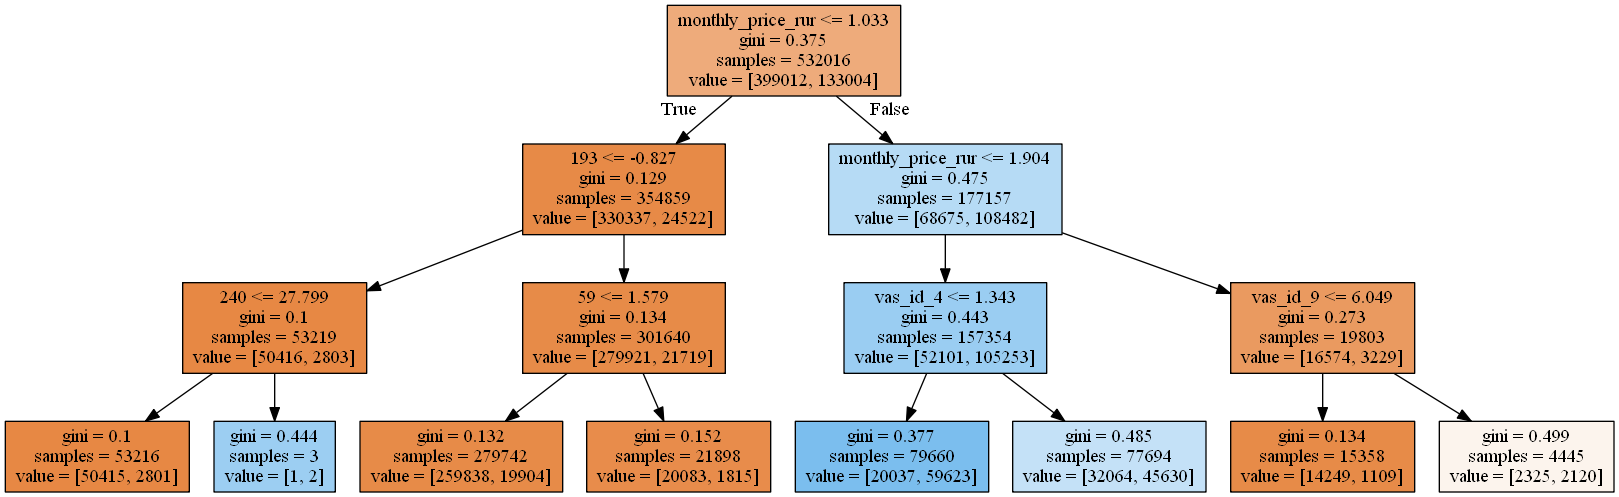

In [84]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

dot_data = StringIO()
export_graphviz(modelLR, feature_names=merged_train_df.columns, 
                out_file=dot_data, filled=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [79]:
merged_train_df.columns[modelLR.feature_importances_ >0]

Index(['191', '193', 'monthly_price_rur', 'vas_id_4', 'vas_id_5', 'vas_id_9'], dtype='object')

Попробуем нейросети

In [30]:
seed = 7
np.random.seed(seed)
n_features = x_train.shape[1]

model = Sequential()
model.add(Dense(16, activation='relu', input_dim=n_features))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(x_train[tr_ind], y_train[tr_ind], 
          validation_data=(x_validation, y_validation),
          batch_size=32,
          epochs=10)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 532016 samples, validate on 1810464 samples
Epoch 1/10
532016/532016 [==============================] - 57s 106us/step - loss: 0.3746 - acc: 0.8465 - val_loss: 0.2506 - val_acc: 0.8664
Epoch 2/10
532016/532016 [==============================] - 50s 94us/step - loss: 0.3664 - acc: 0.8501 - val_loss: 0.2672 - val_acc: 0.8629
Epoch 3/10
532016/532016 [==============================] - 51s 95us/step - loss: 0.3656 - acc: 0.8503 - val_loss: 0.2539 - val_acc: 0.8649
Epoch 4/10
532016/532016 [==============================] - 50s 94us/step - loss: 0.3652 - acc: 0.8504 - val_loss: 0.2495 - val_acc: 0.8654
Epoch 5/10
532016/532016 [==============================] - 50s 95us/step - loss: 0.3650 - acc: 0.8504 - val_loss: 0.2555 - val_acc: 0.8644
Epoch 6/10
532016/532016 [==============================] - 50s 95us/step - loss: 0.3649 - acc: 0.8505 - val_loss: 0.2562 - va

In [31]:
predicted = model.predict_classes(x_validation)
expected = y_validation

In [32]:
print(accuracy_score(expected, predicted))
print(f1_score(expected, predicted, average='macro'))
print(classification_report(expected, predicted))

0.8652019592767379
0.6916244339745671
              precision    recall  f1-score   support

           0       0.98      0.87      0.92   1678150
           1       0.33      0.79      0.46    132314

   micro avg       0.87      0.87      0.87   1810464
   macro avg       0.65      0.83      0.69   1810464
weighted avg       0.93      0.87      0.89   1810464



In [34]:
model_json = model.to_json()
json_file = open("model.json", "w")
json_file.write(model_json)
json_file.close()

model.save_weights("model.h5")
print("Сохранение сети завершено")

Сохранение сети завершено


## Подготовка файла с ответами

In [86]:
del(merged_train_df)
del(scal_train_data)

In [87]:
gc.collect()

560

In [88]:
merged_test_df = test_df.merge(features_df, on='id')
merged_test_df = merged_test_df.merge(price_df, on='vas_id')

In [89]:
merged_test_df.head()

,id,vas_id,buy_time_x,Unnamed: 0,buy_time_y,0,1,2,3,4,...,244,245,246,247,248,249,250,251,252,monthly_price_rur
0,540968,8,1537131600,3756522,1541970000,-31.559971,327.360901,-45.500786,274.753204,-50.918247,...,-613.770813,-20.996269,-37.630447,-28.747725,4.167111,7.305572,-12.175933,21.543859,0.0,499
1,3173665,8,1532898000,1513933,1537736400,-67.149971,-372.599121,-81.090782,-425.206787,-86.508247,...,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.456140,0.0,499
2,3022623,8,1538946000,74045,1539550800,-20.919971,-127.549110,-34.860786,-180.156799,-40.278248,...,-613.770813,-23.996269,-34.630447,-138.747726,-10.832889,-0.694429,1.824067,-0.456140,1.0,499
3,2958020,8,1536526800,902436,1539550800,-94.259972,-193.779114,-103.960785,-233.666794,-109.378242,...,-564.770813,-17.996269,7.369552,129.252274,25.167112,-0.694429,37.824066,-0.456140,1.0,499
4,2371954,8,1533502800,289328,1547413200,-96.799973,91.820885,-110.740784,39.213203,-116.158249,...,934.229187,-22.996269,43.369553,1202.252319,-3.832889,-0.694429,-12.175933,-0.456140,0.0,499


In [90]:
saver = merged_test_df[['id', 'vas_id', 'buy_time_x']]

In [91]:
merged_test_df = pd.get_dummies(merged_test_df, columns=['vas_id'])
merged_test_df.drop(['buy_time_x', 'Unnamed: 0', 'buy_time_y', 'id'], axis=1, inplace=True)
merged_test_df.insert(256, "vas_id_3", 0)
merged_test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,monthly_price_rur,vas_id_1,vas_id_2,vas_id_3,vas_id_4,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9
0,-31.559971,327.360901,-45.500786,274.753204,-50.918247,253.648209,49.15382,195.883896,-1.835267,-12.831245,...,499,0,0,0,0,0,0,0,1,0
1,-67.149971,-372.599121,-81.090782,-425.206787,-86.508247,-446.311798,-16.08618,-65.076096,-6.783660,-30.006538,...,499,0,0,0,0,0,0,0,1,0
2,-20.919971,-127.549110,-34.860786,-180.156799,-40.278248,-201.261795,-16.08618,-65.076096,-6.783660,-30.006538,...,499,0,0,0,0,0,0,0,1,0
3,-94.259972,-193.779114,-103.960785,-233.666794,-109.378242,-254.771790,-16.08618,-65.076096,-6.783660,-30.006538,...,499,0,0,0,0,0,0,0,1,0
4,-96.799973,91.820885,-110.740784,39.213203,-116.158249,18.108210,-16.08618,434.923889,-6.783660,469.993469,...,499,0,0,0,0,0,0,0,1,0


In [92]:
scal_test_data = scaler.transform(merged_test_df)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float32, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [93]:
predicted_classes = model.predict_classes(scal_test_data)

'''print(pd.Series(predicted_classes).value_counts(normalize=True))
print(pd.Series(predicted_classes).value_counts())'''

'print(pd.Series(predicted_classes).value_counts(normalize=True))\nprint(pd.Series(predicted_classes).value_counts())'

In [94]:
saver['target'] = predicted_classes
saver.rename(columns={'buy_time_x':'buy_time'}, inplace=True)
saver.head()

,id,vas_id,buy_time,target
0,540968,8,1537131600,0
1,3173665,8,1532898000,0
2,3022623,8,1538946000,0
3,2958020,8,1536526800,0
4,2371954,8,1533502800,0


Добавим к датафрейму с тестовыми данными наши пресказания

In [95]:
prediction = test_df.merge(saver, on=['id', 'vas_id','buy_time'])
prediction.head(10)

,id,vas_id,buy_time,target
0,540968,8,1537131600,0
1,1454121,4,1531688400,1
2,2458816,1,1534107600,0
3,3535012,5,1535922000,0
4,1693214,1,1535922000,0
5,3173665,8,1532898000,0
6,2611143,2,1544994000,0
7,3577737,5,1545598800,0
8,2000856,1,1534712400,0
9,1232876,2,1544994000,0


In [96]:
test_df.head(10)

,id,vas_id,buy_time
0,540968,8,1537131600
1,1454121,4,1531688400
2,2458816,1,1534107600
3,3535012,5,1535922000
4,1693214,1,1535922000
5,3173665,8,1532898000
6,2611143,2,1544994000
7,3577737,5,1545598800
8,2000856,1,1534712400
9,1232876,2,1544994000


Посмотрим на размеры датафреймов, чтобы не было ошибок

In [97]:
print(test_df.shape, prediction.shape, merged_test_df.shape, saver.shape)

(902884, 3) (902884, 4) (902884, 263) (902884, 4)


Проверим порядок строк в датафрейме с результатами относительно данных из test.csv

In [98]:
print(np.sum(np.abs(test_df.buy_time.values - saver.buy_time.values)))
print(np.sum(np.abs(test_df.buy_time.values - prediction.buy_time.values)))

5280643065600
0


Сохраним файл с предсказаниями

In [99]:
prediction.to_csv('prediction_beta_nn.csv', index = False, sep = '\t')

In [101]:
prediction[prediction.target == 1].vas_id.value_counts()

4    87277
6    70744
9      439
2       25
1       16
5        6
7        2
8        1
Name: vas_id, dtype: int64

### Персонализированные предложения

In [102]:
target_df = pd.read_csv('target_users.csv',  sep='\t')
target_df.head()

,id
0,1834535
1,2076220
2,2026698
3,1092893
4,656446


In [103]:
target_df = pd.concat([target_df]*9, ignore_index=True)
target_df['vas_id'] = list(range(1, 10)) * int(target_df.shape[0]/9)
target_df.sort_values(['id', 'vas_id'], inplace=True)
target_df.head(10)

,id,vas_id
9,656446,1
19,656446,2
29,656446,3
39,656446,4
4,656446,5
14,656446,6
24,656446,7
34,656446,8
44,656446,9
18,1092893,1


In [104]:
merged_target = target_df.merge(features_df, on='id')
merged_target = merged_target.merge(price_df, on='vas_id')

In [105]:
merged_target.head()

,id,vas_id,Unnamed: 0,buy_time,0,1,2,3,4,5,...,244,245,246,247,248,249,250,251,252,monthly_price_rur
0,656446,1,1346722,1534712400,-72.719971,545.820862,-82.420784,552.533203,-87.838249,556.838196,...,-566.770813,-25.996269,-3.630448,-260.747711,-25.832888,-0.694429,-12.175933,-0.45614,0.0,199
1,1092893,1,3412663,1531688400,-62.899971,-371.739105,-72.600784,-420.106812,-78.018250,-441.211792,...,-613.770813,-25.996269,-37.630447,-306.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,199
2,1834535,1,3040805,1538341200,369.300018,290.970886,355.359222,386.663208,349.941742,365.558197,...,3036.229248,-25.996269,-36.630447,-158.747726,-25.832888,-0.694429,-12.175933,-0.45614,0.0,199
3,2026698,1,3108893,1537131600,-96.799973,185.040894,-110.740784,184.983200,-116.158249,163.878204,...,3905.229248,-25.996269,-37.630447,275.252289,-18.832888,-0.694429,-5.175933,-0.45614,0.0,199
4,2076220,1,3007617,1544994000,645.070007,370.810883,636.209229,323.283203,630.791748,302.178223,...,-613.770813,-25.996269,-37.630447,-271.747711,-25.832888,-0.694429,-12.175933,-0.45614,1.0,199


In [106]:
saver = merged_target[['id', 'vas_id']]

In [107]:
merged_target = pd.get_dummies(merged_target, columns=['vas_id'])
merged_target.drop([ 'Unnamed: 0',  'id', 'buy_time'], axis=1, inplace=True)
merged_target.head()

,0,1,2,3,4,5,6,7,8,9,...,monthly_price_rur,vas_id_1,vas_id_2,vas_id_3,vas_id_4,vas_id_5,vas_id_6,vas_id_7,vas_id_8,vas_id_9
0,-72.719971,545.820862,-82.420784,552.533203,-87.838249,556.838196,0.86382,-46.076096,10.16634,-13.056539,...,199,1,0,0,0,0,0,0,0,0
1,-62.899971,-371.739105,-72.600784,-420.106812,-78.018250,-441.211792,17.81382,-31.176098,-6.78366,-30.006538,...,199,1,0,0,0,0,0,0,0,0
2,369.300018,290.970886,355.359222,386.663208,349.941742,365.558197,-16.08618,-65.076096,-6.78366,-30.006538,...,199,1,0,0,0,0,0,0,0,0
3,-96.799973,185.040894,-110.740784,184.983200,-116.158249,163.878204,-16.08618,-65.076096,-6.78366,-30.006538,...,199,1,0,0,0,0,0,0,0,0
4,645.070007,370.810883,636.209229,323.283203,630.791748,302.178223,-16.08618,-65.076096,-6.78366,-30.006538,...,199,1,0,0,0,0,0,0,0,0


In [108]:
scal_target_data = scaler.transform(merged_target)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype uint8, float32, int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [109]:
predicted_classes = modelLR.predict_proba(scal_target_data)

In [110]:
saver['target'] = predicted_classes[:,1]
saver.rename(columns={'buy_time_x':'buy_time'}, inplace=True)
saver.head(10)

,id,vas_id,target
0,656446,1,0.071103
1,1092893,1,0.071103
2,1834535,1,0.071103
3,2026698,1,0.071103
4,2076220,1,0.071103
5,656446,2,0.071103
6,1092893,2,0.071103
7,1834535,2,0.071103
8,2026698,2,0.071103
9,2076220,2,0.071103


In [111]:
saver.to_csv('personal_prediction_des_tree.csv', index = False, sep = ';')

In [79]:
merged_test_df.columns[modelLR.feature_importances_ >0]

Index(['191', '193', 'monthly_price_rur', 'vas_id_4', 'vas_id_5', 'vas_id_9'], dtype='object')